In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import string
import time
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/My Drive/Data/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
def load_descriptions(doc):
	mapping = dict()
	
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))


Loaded: 8092 


In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
def clean_descriptions(descriptions):
	# translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
def to_vocabulary(descriptions):
	# list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc


vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
#def save_descriptions(descriptions, filename):
#	lines = list()
#	for key, desc_list in descriptions.items():
#		for desc in desc_list:
#			lines.append(key + ' ' + desc)
#	data = '\n'.join(lines)
#	file = open(filename, 'w')
#	file.write(data)
#	file.close()
#
#save_descriptions(descriptions, '/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/descriptions.txt')

In [ ]:
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 372935
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [ ]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [ ]:
len(all_vocab)

1839

In [ ]:
# TrainImagesFile
f = open("/content/drive/My Drive/Data/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [ ]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [ ]:
# TestImagesFile
f = open("/content/drive/My Drive/Data/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [ ]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [ ]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [ ]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102858752/102853048 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
# removing the last layer (output layer of 1000 classes) from the resnet

model_new = Model(model.input, model.layers[-2].output)

model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
images = "/content/drive/My Drive/Data/Flicker8k_Dataset/"

In [ ]:
print(len(images))


47


In [ ]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
from time import time
start = time()
encoding_train = {}

for ix, img in enumerate(train):
    
    img = "/content/drive/My Drive/Data/Flicker8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

In [ ]:
with open("/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
#from time import time
#start = time()
#encoding_test = {}

#for ix, img in enumerate(test):

    #img = "/content/drive/My Drive/Data/Flicker8k_Dataset/{}.jpg".format(test[ix])
    #encoding_test[img[len(images):]] = encode_image(img)
    
    #if ix%100==0:
        #print("Encoding image- "+ str(ix))
    
#print("Time taken in seconds =", time()-start)

In [ ]:
#with open("/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/encoded_test_images.pkl", "wb") as encoded_pickle:
   # pickle.dump(encoding_test, encoded_pickle) 

In [ ]:
# loading to memory

with open("/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/encoded_train_images.pkl", "rb") as encoded_pickle:
  encoding_train= pickle.load(encoded_pickle)

In [ ]:
with open("/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/encoded_test_images.pkl", "rb") as encoded_pickle:
  encoding_test= pickle.load(encoded_pickle)

In [ ]:
word_to_idx={}
idx_to_word={}

ix=1
for e in all_vocab:
  word_to_idx[e]=ix
  idx_to_word[ix]=e
  ix=ix+1


In [ ]:
len(word_to_idx)

1839

In [ ]:
len(idx_to_word)

1839

In [ ]:
#adding startseq and endseq to word_to_idx and idx_to_word
word_to_idx['startseq']= 1840
word_to_idx['endseq']= 1841

idx_to_word[1840]= 'startseq'
idx_to_word[1841]= 'endseq'

In [ ]:
vocab_size = len(idx_to_word)+1
print(vocab_size)

1842


In [ ]:
with open('/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/storage/word_to_idx.pkl', 'wb') as W2I:
  pickle.dump(word_to_idx, W2I)

In [ ]:
with open('/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/storage/idx_to_pkl.pkl', 'wb') as I2W:
  pickle.dump(idx_to_word, I2W)

In [ ]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_length, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                                             
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx] 

                #seq=[]
                #for word in desc.split():
                #  if word in word_to_idx:
                #    word_to_idx[word]=word 
                                      
                for i in range(1,len(seq)):
                                  
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                                      
                    in_seq = pad_sequences([in_seq], maxlen=max_length, value=0, padding='post')[0]
                                        
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                                        
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                                  
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [ ]:
# Word Embedding
f = open("/content/drive/My Drive/Data/glove.6b/8542_11957_bundle_archive.zip (Unzipped Files)/glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

print(len(embedding_index)) #number of word vectors

400000


In [ ]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [ ]:
embedding_output.shape

(1842, 50)

In [ ]:
from keras.layers import Input, Dense, Dropout, LSTM, Embedding

In [ ]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
# partial caption sequence model

input_cap = Input(shape=(max_length,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.5)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 50)       92100       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam") 

In [ ]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch


In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/model_weights new/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 188s 94ms/step - loss: 4.3983
Epoch 1/1
2000/2000 [==============================] - 176s 88ms/step - loss: 3.7233
Epoch 1/1
2000/2000 [==============================] - 169s 85ms/step - loss: 3.4799
Epoch 1/1
2000/2000 [==============================] - 177s 88ms/step - loss: 3.3352
Epoch 1/1
2000/2000 [==============================] - 179s 89ms/step - loss: 3.2365
Epoch 1/1
2000/2000 [==============================] - 181s 91ms/step - loss: 3.1659
Epoch 1/1
2000/2000 [==============================] - 184s 92ms/step - loss: 3.1058
Epoch 1/1
2000/2000 [==============================] - 187s 94ms/step - loss: 3.0606
Epoch 1/1
2000/2000 [==============================] - 183s 91ms/step - loss: 3.0246
Epoch 1/1
2000/2000 [==============================] - 182s 91ms/step - loss: 2.9892


In [ ]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/model_weights new/model_' + str(i) + '.h5')                   

Epoch 1/1
2000/2000 [==============================] - 176s 88ms/step - loss: 2.9614
Epoch 1/1
2000/2000 [==============================] - 175s 87ms/step - loss: 2.9350
Epoch 1/1
2000/2000 [==============================] - 172s 86ms/step - loss: 2.9162
Epoch 1/1
2000/2000 [==============================] - 173s 86ms/step - loss: 2.8944
Epoch 1/1
2000/2000 [==============================] - 170s 85ms/step - loss: 2.8811
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8644
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8504
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8365
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8275
Epoch 1/1
2000/2000 [==============================] - 168s 84ms/step - loss: 2.8152


In [ ]:
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/model_weights new/model_' + str(i) + '.h5')  

Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.7583
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.7391
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.7337
Epoch 1/1
1000/1000 [==============================] - 96s 96ms/step - loss: 2.7217
Epoch 1/1
1000/1000 [==============================] - 95s 95ms/step - loss: 2.7120
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.7045
Epoch 1/1
1000/1000 [==============================] - 97s 97ms/step - loss: 2.6994
Epoch 1/1
1000/1000 [==============================] - 96s 96ms/step - loss: 2.6866
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.6860
Epoch 1/1
1000/1000 [==============================] - 93s 93ms/step - loss: 2.6757


In [ ]:
model = load_model("/content/drive/My Drive/Lokesh Image Captioning/WEB Image Captioning/model_weights new/model_9.h5")

In [ ]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
       
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

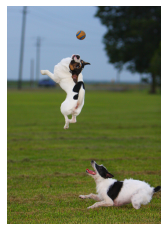

two dogs are playing with frisbee in field


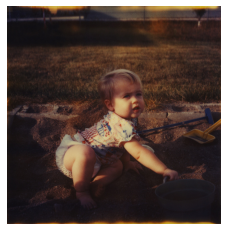

little boy in blue shirt is lying on the wheel


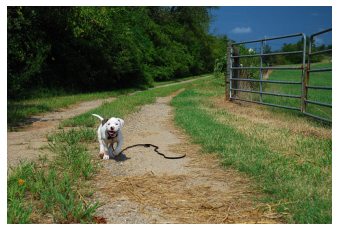

two dogs are running through the grass


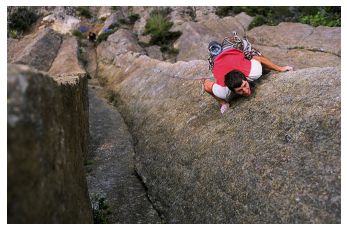

man in red shirt is climbing rock face


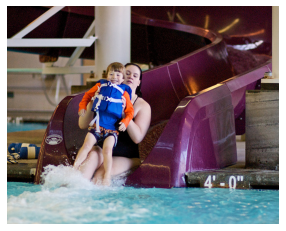

young boy in life vest is splashing in the air


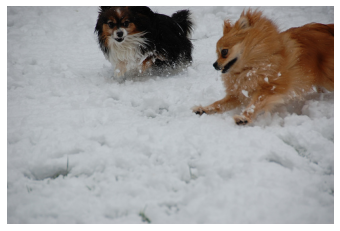

dog is running through the snow


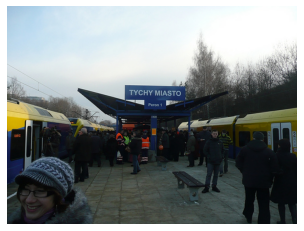

people are sitting in front of large building


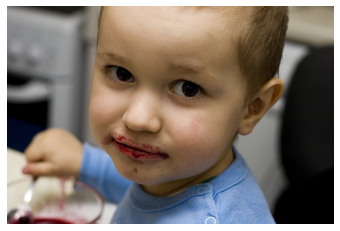

little boy with lips nose is wearing red shirt


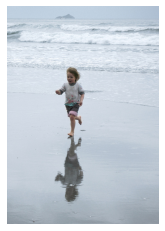

young girl in pink tank top is running through the water


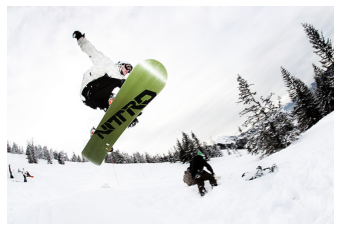

snowboarder in plaid pants is jumping over structure


In [ ]:
for i in range(10):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)